# Multi-Objective Bayesian Optimization for RegionalExpertNet Mass Spectrometry Model

This notebook implements multi-objective Bayesian optimization using Ax and BoTorch for hyperparameter tuning of a RegionalExpertNet neural network for mass spectrometry prediction.

## Mathematical Framework

### Multi-Objective Optimization Problem

We solve the multi-objective optimization problem:

$$\mathbf{x}^* = \arg\max_{\mathbf{x} \in \mathcal{X}} [f_1(\mathbf{x}), -f_2(\mathbf{x})]$$

Where:
- $f_1(\mathbf{x})$ = Cosine similarity (maximize)
- $f_2(\mathbf{x})$ = RMSE (minimize, hence negated)
- $\mathcal{X}$ = Hyperparameter search space

### RegionalExpertNet Architecture

RegionalExpertNet uses specialized expert networks for different m/z regions:

$$y_i = \text{Expert}_i(x) \cdot w_i$$
$$w = \text{softmax}(\text{Router}(x) / T)$$
$$y = \sum_{i=1}^{R} w_i \cdot y_i$$

### Batch Acquisition Function

We use qNEHVI (quasi-Noisy Expected Hypervolume Improvement) for batch acquisition:

$$\alpha_{qNEHVI}(\mathbf{X}) = \mathbb{E}[HV(\mathcal{P} \cup f(\mathbf{X})) - HV(\mathcal{P})]$$

Where $\mathcal{P}$ is the current Pareto frontier and $HV$ is the hypervolume indicator.

## 1. Environment Setup and Thread Control

Set environment variables before importing numerical libraries to prevent thread oversubscription.

In [1]:
# Prevent thread oversubscription for parallel processing
import os
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("VECLIB_MAXIMUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")

import json
import pickle
import warnings
import logging
from typing import Dict, Any, Tuple, List, Optional, Union
from datetime import datetime
from dataclasses import dataclass, field
from pathlib import Path
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr, spearmanr
from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Force CPU usage for torch (MPS doesn't work well with BoTorch)
torch.set_default_device("cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(-1)  # Disable CUDA
    
# Ax and BoTorch imports
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Generators
from ax.core.optimization_config import MultiObjectiveOptimizationConfig
from ax.core.objective import MultiObjective, Objective
from ax.core.metric import Metric
from ax.core.outcome_constraint import ObjectiveThreshold
from ax.core.types import ComparisonOp

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

logger.info(f"Environment setup complete. CPU count: {os.cpu_count()}")
logger.info(f"Torch device: CPU (required for BoTorch stability)")
logger.info("Multi-objective optimization with Ax/BoTorch initialized")

[WARNING 08-18 12:24:20] ax.service.utils.with_db_settings_base: Ax currently requires a sqlalchemy version below 2.0. This will be addressed in a future release. Disabling SQL storage in Ax for now, if you would like to use SQL storage please install Ax with mysql extras via `pip install ax-platform[mysql]`.
/var/folders/_g/yv_ycc0s11z1x8zk__56l6r80000gn/T/ipykernel_39745/775684969.py:45: DeprecationWarning: Please import from 'ax.generation_strategy.generation_strategy' instead of 'ax.modelbridge.generation_strategy'. The latter is deprecated and will be removed in a future release.
  from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
2025-08-18 12:24:20,993 - INFO - Environment setup complete. CPU count: 16
2025-08-18 12:24:20,993 - INFO - Torch device: CPU (required for BoTorch stability)
2025-08-18 12:24:20,994 - INFO - Multi-objective optimization with Ax/BoTorch initialized


## 2. Configuration Dataclass

Using dataclasses for clean configuration management following SOLID principles.

In [2]:
@dataclass
class OptimizationConfig:
    """Configuration for Bayesian optimization."""
    # Data paths
    results_dir: Path = Path('../data/results')
    models_dir: Path = Path('../models/bayesian_optimized')
    input_type: str = 'hpj'
    use_selected_data: bool = False
    
    # Data processing
    transform_sqrt: bool = True
    validation_split: float = 0.2
    random_state: int = 42
    
    # Optimization settings
    n_iterations: int = 50
    n_initial_points: int = 14  # Sobol initialization
    batch_size: int = 8  # Parallel evaluations (smaller for NN)
    
    # Speed optimization for NN
    max_epochs_eval: int = 30  # Limit epochs during evaluation
    early_stopping_patience: int = 5  # Early stopping for eval
    row_subsample_frac: float = 0.3  # Subsample for faster evaluation
    max_bins_eval: int = 512  # Limit bins for evaluation
    
    # Multi-objective settings
    objectives: List[str] = field(default_factory=lambda: ['cosine_similarity', 'rmse'])
    minimize: List[bool] = field(default_factory=lambda: [False, True])
    
    # Final training settings
    final_max_epochs: int = 100
    final_patience: int = 15
    
    def __post_init__(self):
        self.models_dir.mkdir(parents=True, exist_ok=True)
        
    @property
    def data_dir(self) -> Path:
        subdir = 'selected' if self.use_selected_data else 'full_featurised'
        return self.results_dir / self.input_type / subdir
    
    def get_data_paths(self) -> Dict[str, Path]:
        return {
            'train': self.data_dir / 'train_data.jsonl',
            'val': self.data_dir / 'val_data.jsonl',
            'test': self.data_dir / 'test_data.jsonl'
        }

config = OptimizationConfig()

## 3. Data Loading and Preprocessing

Efficient data loading with vectorized operations and proper scaler management.

In [3]:
class DataLoader:
    """Handles data loading and preprocessing."""
    
    @staticmethod
    def load_jsonl(filepath: Path) -> Tuple[List[str], np.ndarray, np.ndarray]:
        """Load data from JSONL file."""
        if not filepath.exists():
            raise FileNotFoundError(f"File not found: {filepath}")
        
        data = []
        with open(filepath, 'r') as f:
            for line in tqdm(f, desc=f"Loading {filepath.name}"):
                try:
                    record = json.loads(line)
                    if all(k in record for k in ['smiles', 'features', 'target']):
                        data.append(record)
                except json.JSONDecodeError:
                    continue
        
        if not data:
            raise ValueError(f"No valid data in {filepath}")
        
        smiles = [d['smiles'] for d in data]
        features = np.array([d['features'] for d in data])
        targets = np.array([d['target'] for d in data])
        
        logger.info(f"Loaded {len(smiles)} samples from {filepath.name}")
        return smiles, features, targets
    
    @staticmethod
    def prepare_data(config: OptimizationConfig) -> Dict[str, Any]:
        """Load and prepare all data using existing train/val/test splits."""
        paths = config.get_data_paths()
        
        # Load all three splits
        train_smiles, X_train, y_train = DataLoader.load_jsonl(paths['train'])
        val_smiles, X_val, y_val = DataLoader.load_jsonl(paths['val'])
        test_smiles, X_test, y_test = DataLoader.load_jsonl(paths['test'])
        
        # Apply transformation
        if config.transform_sqrt:
            y_train = np.sqrt(np.maximum(y_train, 0))
            y_val = np.sqrt(np.maximum(y_val, 0))
            y_test = np.sqrt(np.maximum(y_test, 0))
        
        # Create subsampled indices for fast evaluation during optimization
        rng = np.random.RandomState(config.random_state)
        n_subsample = int(len(X_val) * config.row_subsample_frac)
        row_idx = rng.choice(len(X_val), n_subsample, replace=False)
        bin_idx = slice(None, min(config.max_bins_eval, y_val.shape[1]))
        
        # Scale features for optimization - fit on train, apply to val
        opt_scaler = StandardScaler()
        X_train_scaled = opt_scaler.fit_transform(X_train)
        X_val_scaled = opt_scaler.transform(X_val)
        
        # Subsampled validation data for fast evaluation
        X_val_sub = X_val_scaled[row_idx]
        y_val_sub = y_val[row_idx][:, bin_idx]
        
        # Separate scaler for final training (refit on full train for final model)
        final_scaler = StandardScaler()
        X_train_final = final_scaler.fit_transform(X_train)
        X_test_scaled = final_scaler.transform(X_test)
        
        return {
            'X_opt_train': X_train_scaled,  # For optimization
            'X_opt_val': X_val_scaled,      # Full validation
            'y_opt_train': y_train,
            'y_opt_val': y_val,
            'X_opt_val_sub': X_val_sub,     # Subsampled validation
            'y_opt_val_sub': y_val_sub,
            'X_train': X_train_final,       # For final training
            'X_test': X_test_scaled,        # For final evaluation
            'y_train': y_train,
            'y_val': y_val,                 # Keep original val
            'y_test': y_test,
            'opt_scaler': opt_scaler,
            'final_scaler': final_scaler,
            'bin_idx': bin_idx,
            'input_dim': X_train.shape[1],
            'output_dim': y_train.shape[1]
        }

# Load data
data = DataLoader.prepare_data(config)
logger.info(f"Data shapes - Train: {data['X_opt_train'].shape}, Val: {data['X_opt_val'].shape}, Test: {data['X_test'].shape}")
logger.info(f"Subsampled val for fast eval: {data['X_opt_val_sub'].shape}")

Loading train_data.jsonl: 0it [00:00, ?it/s]

2025-08-18 12:24:22,393 - INFO - Loaded 2176 samples from train_data.jsonl


Loading val_data.jsonl: 0it [00:00, ?it/s]

2025-08-18 12:24:22,613 - INFO - Loaded 272 samples from val_data.jsonl


Loading test_data.jsonl: 0it [00:00, ?it/s]

2025-08-18 12:24:22,776 - INFO - Loaded 272 samples from test_data.jsonl
2025-08-18 12:24:22,924 - INFO - Data shapes - Train: (2176, 7137), Val: (272, 7137), Test: (272, 7137)
2025-08-18 12:24:22,924 - INFO - Subsampled val for fast eval: (81, 7137)


## 4. Neural Network Architecture Components

Define RegionalExpertNet architecture with configurable components.

In [4]:
# Activation function mapping
ACTIVATION_FUNCTIONS = {
    'relu': nn.ReLU,
    'elu': nn.ELU,
    'gelu': nn.GELU,
    'selu': nn.SELU
}

class RegionalExpert(nn.Module):
    """Expert network for a specific m/z region"""
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers, 
                 activation='relu', dropout=0.1, use_batch_norm=True):
        super().__init__()
        
        activation_fn = ACTIVATION_FUNCTIONS[activation]
        layers = []
        
        # Build layers
        current_dim = input_dim
        for i in range(num_layers):
            layers.append(nn.Linear(current_dim, hidden_dim))
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(activation_fn())
            layers.append(nn.Dropout(dropout))
            current_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(hidden_dim, output_dim))
        layers.append(nn.ReLU())  # Non-negative outputs
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

class RegionalExpertNet(nn.Module):
    """RegionalExpertNet with configurable architecture."""
    def __init__(self, input_dim, output_dim, config):
        super().__init__()
        
        # Extract configuration
        num_regions = config['num_regions']
        region_size = config['region_size']
        expert_layers = config['expert_layers']
        expert_hidden = config['expert_hidden']
        router_hidden = config['router_hidden']
        overlap_bins = config['overlap_bins']
        activation = config.get('activation', 'relu')
        dropout = config.get('dropout', 0.1)
        use_batch_norm = config.get('use_batch_norm', True)
        use_global_features = config.get('use_global_features', True)
        self.router_temperature = config.get('router_temperature', 1.0)
        self.output_dim = output_dim
        
        # Calculate expert regions with proper bounds checking
        self.expert_regions = []
        for i in range(num_regions):
            start = i * region_size
            end = min((i + 1) * region_size, output_dim)
            if start < output_dim:  # Only add if start is within bounds
                self.expert_regions.append((start, end))
        
        # Adjust num_regions if necessary
        actual_num_regions = len(self.expert_regions)
        if actual_num_regions == 0:
            # Fallback: create at least one region covering the entire output
            self.expert_regions = [(0, output_dim)]
            actual_num_regions = 1
        
        self.overlap_bins = overlap_bins
        
        # Create experts with proper dimension handling
        self.experts = nn.ModuleList()
        for start, end in self.expert_regions:
            # Calculate region size with overlap
            region_width = end - start
            
            # Add overlap but ensure we don't exceed output_dim
            actual_start = max(0, start - overlap_bins)
            actual_end = min(output_dim, end + overlap_bins)
            expert_output_dim = actual_end - actual_start
            
            # Ensure expert_output_dim is at least 1
            expert_output_dim = max(1, expert_output_dim)
            
            self.experts.append(
                RegionalExpert(
                    input_dim, expert_output_dim, expert_hidden, 
                    expert_layers, activation, dropout, use_batch_norm
                )
            )
        
        # Router network
        activation_fn = ACTIVATION_FUNCTIONS[activation]
        router_layers = [
            nn.Linear(input_dim, router_hidden),
            activation_fn(),
            nn.Dropout(dropout),
            nn.Linear(router_hidden, actual_num_regions)
        ]
        self.router = nn.Sequential(*router_layers)
        
        # Global features (optional)
        if use_global_features:
            self.global_features = nn.Sequential(
                nn.Linear(input_dim, router_hidden),
                nn.BatchNorm1d(router_hidden) if use_batch_norm else nn.Identity(),
                activation_fn(),
                nn.Dropout(dropout)
            )
            
            # Fusion layer
            self.fusion = nn.Sequential(
                nn.Linear(router_hidden, output_dim),
                nn.Sigmoid()
            )
        else:
            self.global_features = None
            self.fusion = None
        
        # Expert-specific scaling factors
        self.expert_scales = nn.Parameter(torch.ones(actual_num_regions))
    
    def forward(self, x):
        # Get routing weights
        routing_logits = self.router(x)
        routing_weights = F.softmax(routing_logits / self.router_temperature, dim=1)
        
        # Get global features if enabled
        if self.global_features is not None:
            global_feat = self.global_features(x)
            fusion_weights = self.fusion(global_feat)
        else:
            fusion_weights = None
        
        # Initialize output
        batch_size = x.shape[0]
        output = torch.zeros(batch_size, self.output_dim).to(x.device)
        
        # Process each expert
        for i, ((start, end), expert) in enumerate(zip(self.expert_regions, self.experts)):
            # Get expert prediction
            expert_pred = expert(x)
            
            # Apply expert-specific scaling
            expert_pred = expert_pred * self.expert_scales[i]
            
            # Calculate actual region with overlap
            actual_start = max(0, start - self.overlap_bins)
            actual_end = min(self.output_dim, end + self.overlap_bins)
            
            # Extract relevant portion and apply routing weights
            region_size = actual_end - actual_start
            expert_size = expert_pred.shape[1]
            
            # Take minimum of sizes to avoid dimension mismatch
            copy_size = min(region_size, expert_size)
            
            if copy_size > 0:
                weighted_pred = expert_pred[:, :copy_size] * routing_weights[:, i:i+1]
                output[:, actual_start:actual_start+copy_size] += weighted_pred
        
        # Apply global fusion if enabled
        if fusion_weights is not None:
            output = output * fusion_weights + output * (1 - fusion_weights)
        
        return output
    
    def get_routing_entropy(self, x):
        """Calculate routing entropy for regularization."""
        routing_logits = self.router(x)
        routing_weights = F.softmax(routing_logits / self.router_temperature, dim=1)
        entropy = -(routing_weights * torch.log(routing_weights + 1e-8)).sum(dim=1).mean()
        return entropy

## 5. Metrics and Helper Functions

Define metrics computation and training utilities.

In [5]:
class MetricsComputer:
    """Compute evaluation metrics."""
    
    @staticmethod
    def cosine_similarity(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """Compute mean cosine similarity."""
        # Vectorized cosine similarity
        dot_product = np.sum(y_true * y_pred, axis=1)
        norm_true = np.linalg.norm(y_true, axis=1)
        norm_pred = np.linalg.norm(y_pred, axis=1)
        
        # Avoid division by zero
        valid_mask = (norm_true > 0) & (norm_pred > 0)
        similarities = np.zeros(len(y_true))
        similarities[valid_mask] = dot_product[valid_mask] / (norm_true[valid_mask] * norm_pred[valid_mask])
        
        return float(np.mean(similarities))
    
    @staticmethod
    def compute_all_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
        """Compute all evaluation metrics."""
        return {
            'cosine_similarity': MetricsComputer.cosine_similarity(y_true, y_pred),
            'rmse': float(np.sqrt(mean_squared_error(y_true, y_pred))),
            'mae': float(mean_absolute_error(y_true, y_pred)),
            'r2': float(r2_score(y_true, y_pred))
        }

# Loss functions
def sparsity_loss(pred):
    """L1 regularization to encourage sparsity."""
    return pred.abs().mean()

def cosine_loss(pred, true, eps=1e-8):
    """Cosine distance loss."""
    num = (pred * true).sum(1)
    den = torch.norm(pred, 2, 1) * torch.norm(true, 2, 1) + eps
    return 1.0 - (num / den).mean()

def create_optimizer(model, config):
    """Create optimizer based on configuration."""
    optimizer_name = config.get('optimizer', 'adam')
    lr = config['learning_rate']
    weight_decay = config.get('weight_decay', 0.0)
    
    if optimizer_name == 'adam':
        return torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'adamw':
        return torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'sgd':
        return torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=0.9)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

def create_scheduler(optimizer, config, num_epochs):
    """Create learning rate scheduler."""
    scheduler_name = config.get('scheduler', 'none')
    
    if scheduler_name == 'reduce_on_plateau':
        return ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    elif scheduler_name == 'cosine':
        return CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
    else:
        return None

## 6. Search Space Definition

Define the hyperparameter search space for RegionalExpertNet.

### Search Space Design

We define a comprehensive search space $\mathcal{X}$ covering:

- **Architecture parameters**: Number of regions, region size, expert layers, hidden dimensions
- **Training parameters**: Learning rate, batch size, optimizer, dropout
- **Loss weights**: Balance between MSE, cosine similarity, sparsity, and routing entropy

In [6]:
def create_search_space() -> List[Dict[str, Any]]:
    """Create Ax search space for RegionalExpertNet."""
    return [
        # Architecture parameters
        {
            "name": "num_regions",
            "type": "range",
            "bounds": [2, 8],
            "value_type": "int"
        },
        {
            "name": "region_size",
            "type": "range",
            "bounds": [64, 256],  # Increased minimum to avoid negative dimensions
            "value_type": "int"
        },
        {
            "name": "expert_layers",
            "type": "range",
            "bounds": [1, 3],
            "value_type": "int"
        },
        {
            "name": "expert_hidden",
            "type": "range",
            "bounds": [64, 256],
            "value_type": "int"
        },
        {
            "name": "router_hidden",
            "type": "range",
            "bounds": [32, 128],
            "value_type": "int"
        },
        {
            "name": "overlap_bins",
            "type": "range",
            "bounds": [0, 20],  # Reduced max overlap to avoid dimension issues
            "value_type": "int"
        },
        # Training parameters
        {
            "name": "learning_rate",
            "type": "range",
            "bounds": [1e-5, 1e-2],
            "value_type": "float",
            "log_scale": True
        },
        {
            "name": "batch_size",
            "type": "choice",
            "values": [16, 32, 64, 128],
            "value_type": "int"
        },
        {
            "name": "dropout",
            "type": "range",
            "bounds": [0.0, 0.5],
            "value_type": "float"
        },
        {
            "name": "weight_decay",
            "type": "range",
            "bounds": [0.0, 0.01],
            "value_type": "float"
        },
        # Optimizer and activation
        {
            "name": "optimizer",
            "type": "choice",
            "values": ["adam", "adamw", "sgd"],
            "value_type": "str"
        },
        {
            "name": "activation",
            "type": "choice",
            "values": ["relu", "elu", "gelu"],
            "value_type": "str"
        },
        # Loss weights
        {
            "name": "weight_mse",
            "type": "range",
            "bounds": [0.1, 2.0],
            "value_type": "float"
        },
        {
            "name": "weight_cosine",
            "type": "range",
            "bounds": [0.0, 3.0],
            "value_type": "float"
        },
        {
            "name": "weight_sparsity",
            "type": "range",
            "bounds": [1e-6, 1e-3],
            "value_type": "float",
            "log_scale": True
        },
        {
            "name": "weight_routing",
            "type": "range",
            "bounds": [0.0, 0.05],
            "value_type": "float"
        },
        # Other hyperparameters
        {
            "name": "router_temperature",
            "type": "range",
            "bounds": [0.5, 2.0],
            "value_type": "float"
        },
        {
            "name": "gradient_clip",
            "type": "range",
            "bounds": [0.0, 5.0],
            "value_type": "float"
        },
        {
            "name": "scheduler",
            "type": "choice",
            "values": ["none", "reduce_on_plateau", "cosine"],
            "value_type": "str"
        },
        {
            "name": "use_batch_norm",
            "type": "choice",
            "values": [True, False],
            "value_type": "bool"
        },
        {
            "name": "use_global_features",
            "type": "choice",
            "values": [True, False],
            "value_type": "bool"
        }
    ]

## 7. Training and Evaluation Function

The core function that trains a RegionalExpertNet model and returns multiple objectives.
Uses subsampled data for faster evaluation during optimization.

In [7]:
def train_and_evaluate_nn(parameters: Dict[str, Any], data: Dict[str, np.ndarray], 
                          config: OptimizationConfig, use_subsample: bool = True) -> Dict[str, float]:
    """Train and evaluate RegionalExpertNet with given parameters.
    
    Args:
        parameters: Hyperparameters to evaluate
        data: Data dictionary
        config: Optimization configuration
        use_subsample: Whether to use subsampled data for faster evaluation
    
    Returns:
        dict with cosine_similarity and rmse values
    """
    try:
        # Select appropriate data and make copies to ensure writability
        if use_subsample:
            X_train = np.array(data['X_opt_train'], copy=True)
            y_train = np.array(data['y_opt_train'][:, data['bin_idx']], copy=True)
            X_val = np.array(data['X_opt_val_sub'], copy=True)
            y_val = np.array(data['y_opt_val_sub'], copy=True)
            output_dim = y_train.shape[1]
        else:
            X_train = np.array(data['X_opt_train'], copy=True)
            y_train = np.array(data['y_opt_train'], copy=True)
            X_val = np.array(data['X_opt_val'], copy=True)
            y_val = np.array(data['y_opt_val'], copy=True)
            output_dim = data['output_dim']
        
        # Model configuration
        model_config = {
            'num_regions': parameters['num_regions'],
            'region_size': parameters['region_size'],
            'expert_layers': parameters['expert_layers'],
            'expert_hidden': parameters['expert_hidden'],
            'router_hidden': parameters['router_hidden'],
            'overlap_bins': parameters['overlap_bins'],
            'activation': parameters['activation'],
            'dropout': parameters['dropout'],
            'use_batch_norm': parameters['use_batch_norm'],
            'use_global_features': parameters['use_global_features'],
            'router_temperature': parameters['router_temperature']
        }
        
        # Initialize model
        model = RegionalExpertNet(data['input_dim'], output_dim, model_config)
        
        # Optimizer config
        opt_config = {
            'optimizer': parameters['optimizer'],
            'learning_rate': parameters['learning_rate'],
            'weight_decay': parameters['weight_decay']
        }
        
        optimizer = create_optimizer(model, opt_config)
        scheduler = create_scheduler(optimizer, parameters, config.max_epochs_eval)
        
        # Create data loaders
        batch_size = min(parameters['batch_size'], len(X_train) // 2)
        
        train_dataset = TensorDataset(
            torch.FloatTensor(X_train),
            torch.FloatTensor(y_train)
        )
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
        )
        
        # Training loop
        best_val_cosine = 0.0
        patience_counter = 0
        
        for epoch in range(config.max_epochs_eval):
            # Training phase
            model.train()
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                
                predictions = model(X_batch)
                routing_entropy = model.get_routing_entropy(X_batch)
                
                # Combined loss
                loss_mse = F.mse_loss(predictions, y_batch)
                loss_cos = cosine_loss(predictions, y_batch)
                loss_sparse = sparsity_loss(predictions)
                
                total_loss = (
                    parameters['weight_mse'] * loss_mse +
                    parameters['weight_cosine'] * loss_cos +
                    parameters['weight_sparsity'] * loss_sparse +
                    parameters['weight_routing'] * routing_entropy
                )
                
                total_loss.backward()
                
                # Gradient clipping
                if parameters['gradient_clip'] > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), parameters['gradient_clip'])
                
                optimizer.step()
            
            # Validation phase
            model.eval()
            with torch.no_grad():
                val_pred = model(torch.FloatTensor(X_val)).numpy()
                val_pred = np.maximum(val_pred, 0)
                
                val_cosine = MetricsComputer.cosine_similarity(y_val, val_pred)
            
            # Learning rate scheduling
            if scheduler is not None:
                if parameters['scheduler'] == 'reduce_on_plateau':
                    scheduler.step(-val_cosine)
                else:
                    scheduler.step()
            
            # Early stopping
            if val_cosine > best_val_cosine:
                best_val_cosine = val_cosine
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= config.early_stopping_patience:
                    break
        
        # Final evaluation
        model.eval()
        with torch.no_grad():
            final_pred = model(torch.FloatTensor(X_val)).numpy()
            final_pred = np.maximum(final_pred, 0)
        
        metrics = MetricsComputer.compute_all_metrics(y_val, final_pred)
        
        return {
            'cosine_similarity': metrics['cosine_similarity'],
            'rmse': metrics['rmse']
        }
        
    except Exception as e:
        logger.error(f"Error in training: {e}")
        # Return worst possible scores on error
        return {
            'cosine_similarity': 0.0,
            'rmse': 1e6
        }

def evaluate_parameters(parameters: Dict[str, Any], data: Dict[str, np.ndarray],
                        config: OptimizationConfig, use_subsample: bool = True) -> Dict[str, Tuple[float, float]]:
    """Wrapper for Ax evaluation that returns (mean, sem) tuples."""
    metrics = train_and_evaluate_nn(parameters, data, config, use_subsample)
    
    return {
        'cosine_similarity': (metrics['cosine_similarity'], 0.0),
        'rmse': (metrics['rmse'], 0.0)
    }

# Helper function for parallel evaluation
def _run_eval(params: Dict[str, Any]) -> Dict[str, Tuple[float, float]]:
    """Wrapper for parallel evaluation - compute only, no AxClient calls."""
    return evaluate_parameters(params, data, config, use_subsample=True)

## 8. Multi-Objective Bayesian Optimization Setup

### Optimization Strategy

1. **Initialization Phase**: Use Sobol sequence for space-filling design
2. **Threshold Setting**: After initialization, set objective thresholds based on observed data
3. **Bayesian Phase**: Use NEHVI for multi-objective acquisition
4. **Parallel Batch Evaluation**: Evaluate multiple candidates in parallel

The Pareto frontier $\mathcal{P}$ is updated after each batch:

$$\mathcal{P}_{t+1} = \text{ParetoFrontier}(\mathcal{P}_t \cup \{f(\mathbf{x}_i)\}_{i=1}^{b})$$

In [8]:
# Initialize Ax client
ax_client = AxClient(verbose_logging=False)

# Create experiment with multi-objective optimization
ax_client.create_experiment(
    name="regional_expertnet_multi_objective",
    parameters=create_search_space(),
    objectives={
        "cosine_similarity": ObjectiveProperties(minimize=False),
        "rmse": ObjectiveProperties(minimize=True)
    },
    overwrite_existing_experiment=True,
    immutable_search_space_and_opt_config=False,  # Allow config updates
)

# Define generation strategy
gs = GenerationStrategy(
    steps=[
        # Sobol initialization for space exploration
        GenerationStep(
            model=Generators.SOBOL,
            num_trials=config.n_initial_points,
            min_trials_observed=config.n_initial_points
        ),
        # Multi-objective Bayesian optimization
        GenerationStep(
            model=Generators.BOTORCH_MODULAR,
            num_trials=-1,  # No limit
        )
    ]
)

ax_client._generation_strategy = gs

logger.info("Starting multi-objective Bayesian optimization for RegionalExpertNet")
logger.info(f"Objectives: maximize cosine_similarity, minimize RMSE")
logger.info(f"Total trials: {config.n_iterations}, Batch size: {config.batch_size}")
logger.info(f"Parallel workers: {min(config.batch_size, os.cpu_count())}")

[WARNING 08-18 12:24:23] ax.service.utils.instantiation: Objective thresholds were not set. They will be selected using a heuristic, but should be specified on the objective for best performance.
[INFO 08-18 12:24:23] ax.generation_strategy.dispatch_utils: Using Generators.BOTORCH_MODULAR since there are more ordered parameters than there are categories for the unordered categorical parameters.
[INFO 08-18 12:24:23] ax.generation_strategy.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+BoTorch', steps=[Sobol for 42 trials, BoTorch for subsequent trials]). Iterations after 42 will take longer to generate due to model-fitting.
2025-08-18 12:24:23,194 - INFO - Starting multi-objective Bayesian optimization for RegionalExpertNet
2025-08-18 12:24:23,194 - INFO - Objectives: maximize cosine_similarity, minimize RMSE
2025-08-18 12:24:23,194 - INFO - Total trials: 50, Batch size: 8
2025-08-18 12:24:23,194 - INFO - Parallel workers: 8


## 9. Optimization Loop - Phase 1: Sobol Initialization

Run Sobol initialization with parallel batch evaluation to explore the space.

In [9]:
# Storage for results
trials_data = []
best_cosine = -np.inf
best_rmse = np.inf

# Start optimization timer
optimization_start_time = time.time()

# Progress bar
pbar = tqdm(total=config.n_iterations, desc="Optimization Progress")

# Phase 1: Sobol initialization with parallel evaluation
logger.info("Phase 1: Sobol initialization with parallel evaluation")
trial_index = 0

while trial_index < config.n_initial_points:
    # Generate batch of trials
    batch_size = min(config.batch_size, config.n_initial_points - trial_index)
    
    batch_trials = []
    for _ in range(batch_size):
        parameters, trial_id = ax_client.get_next_trial()
        batch_trials.append((parameters, trial_id))
    
    # Extract parameters for parallel evaluation
    params_list = [params for params, _ in batch_trials]
    
    # Run evaluations in parallel
    raw_list = Parallel(
        n_jobs=min(config.batch_size, os.cpu_count()),
        backend="loky",
        prefer="processes"
    )(delayed(_run_eval)(p) for p in params_list)
    
    # Log results back to Ax sequentially
    for (parameters, trial_id), raw_data in zip(batch_trials, raw_list):
        try:
            # Complete trial
            ax_client.complete_trial(trial_index=trial_id, raw_data=raw_data)
            
            # Extract metrics
            cosine_sim = raw_data['cosine_similarity'][0]
            rmse = raw_data['rmse'][0]
            
            # Track results
            trial_data = {
                'trial_id': trial_id,
                'parameters': parameters,
                'cosine_similarity': cosine_sim,
                'rmse': rmse,
                'phase': 'sobol'
            }
            trials_data.append(trial_data)
            
            # Update best values
            if cosine_sim > best_cosine:
                best_cosine = cosine_sim
            if rmse < best_rmse:
                best_rmse = rmse
            
            # Update progress
            pbar.set_postfix({
                'Phase': 'Sobol',
                'Best Cosine': f'{best_cosine:.4f}',
                'Best RMSE': f'{best_rmse:.4f}'
            })
            
        except Exception as e:
            logger.error(f"Trial {trial_id} failed: {e}")
            ax_client.log_trial_failure(trial_index=trial_id)
    
    trial_index += batch_size
    pbar.update(batch_size)

logger.info(f"Sobol initialization complete. Setting objective thresholds...")

Optimization Progress:   0%|          | 0/50 [00:00<?, ?it/s]

2025-08-18 12:24:23,255 - INFO - Phase 1: Sobol initialization with parallel evaluation
2025-08-18 12:27:51,796 - INFO - Sobol initialization complete. Setting objective thresholds...


## 10. Set Objective Thresholds

Set objective thresholds based on observed data from Sobol initialization.

In [10]:
# Compute thresholds from observed data
df_sobol = pd.DataFrame(trials_data)
cos_threshold = float(np.percentile(df_sobol["cosine_similarity"], 10))  # Lower bound
rmse_threshold = float(np.percentile(df_sobol["rmse"], 90))             # Upper bound

logger.info(f"Setting thresholds - Cosine >= {cos_threshold:.4f}, RMSE <= {rmse_threshold:.4f}")

# Create metrics
cosine_metric = Metric(name="cosine_similarity")
rmse_metric = Metric(name="rmse")

# Update optimization config with thresholds
ax_client.experiment.optimization_config = MultiObjectiveOptimizationConfig(
    objective=MultiObjective(
        objectives=[
            Objective(metric=cosine_metric, minimize=False),
            Objective(metric=rmse_metric, minimize=True),
        ]
    ),
    objective_thresholds=[
        ObjectiveThreshold(
            metric=cosine_metric,
            bound=cos_threshold,
            op=ComparisonOp.GEQ,
            relative=False
        ),
        ObjectiveThreshold(
            metric=rmse_metric,
            bound=rmse_threshold,
            op=ComparisonOp.LEQ,
            relative=False
        ),
    ],
)

2025-08-18 12:27:51,815 - INFO - Setting thresholds - Cosine >= 0.3078, RMSE <= 0.1500


## 11. Optimization Loop - Phase 2: Bayesian Optimization

Continue with multi-objective Bayesian optimization using NEHVI.

In [11]:
# Phase 2: Bayesian optimization with parallel evaluation
logger.info("Phase 2: Multi-objective Bayesian optimization with NEHVI")

while trial_index < config.n_iterations:
    # Generate batch of trials
    batch_size = min(config.batch_size, config.n_iterations - trial_index)
    
    # Generate trials sequentially (required by Ax for BO phase)
    logger.info(f"Generating batch of {batch_size} trials...")
    batch_start = time.time()
    
    batch_trials = []
    for i in range(batch_size):
        logger.debug(f"Generating trial {i+1}/{batch_size}")
        try:
            parameters, trial_id = ax_client.get_next_trial()
            batch_trials.append((parameters, trial_id))
        except Exception as e:
            logger.warning(f"Could not generate trial {i+1}: {e}")
            break
    
    if not batch_trials:
        logger.warning("No trials generated, stopping optimization")
        break
        
    logger.info(f"Trial generation took {time.time() - batch_start:.1f}s for {len(batch_trials)} trials")
    
    # Extract parameters for parallel evaluation
    params_list = [params for params, _ in batch_trials]
    
    # Run evaluations in parallel
    logger.info(f"Evaluating {len(params_list)} trials in parallel...")
    eval_start = time.time()
    
    raw_list = Parallel(
        n_jobs=min(len(params_list), os.cpu_count()),
        backend="loky",
        prefer="processes",
        verbose=0
    )(delayed(_run_eval)(p) for p in params_list)
    
    logger.info(f"Parallel evaluation took {time.time() - eval_start:.1f}s")
    
    # Log results back to Ax sequentially
    for (parameters, trial_id), raw_data in zip(batch_trials, raw_list):
        try:
            # Complete trial
            ax_client.complete_trial(trial_index=trial_id, raw_data=raw_data)
            
            # Extract metrics
            cosine_sim = raw_data['cosine_similarity'][0]
            rmse = raw_data['rmse'][0]
            
            # Track results
            trial_data = {
                'trial_id': trial_id,
                'parameters': parameters,
                'cosine_similarity': cosine_sim,
                'rmse': rmse,
                'phase': 'bayesian'
            }
            trials_data.append(trial_data)
            
            # Update best values
            if cosine_sim > best_cosine:
                best_cosine = cosine_sim
                logger.info(f"New best cosine: {best_cosine:.4f} at trial {trial_id}")
            if rmse < best_rmse:
                best_rmse = rmse
                logger.info(f"New best RMSE: {best_rmse:.4f} at trial {trial_id}")
            
            # Update progress
            pbar.set_postfix({
                'Phase': 'BO',
                'Best Cosine': f'{best_cosine:.4f}',
                'Best RMSE': f'{best_rmse:.4f}'
            })
            
        except Exception as e:
            logger.error(f"Trial {trial_id} failed: {e}")
            ax_client.log_trial_failure(trial_index=trial_id)
    
    trial_index += batch_size
    pbar.update(batch_size)

pbar.close()

# Calculate total optimization time
optimization_time = time.time() - optimization_start_time

logger.info(f"Optimization complete in {optimization_time:.1f} seconds")
logger.info(f"Best cosine: {best_cosine:.4f}, Best RMSE: {best_rmse:.4f}")

2025-08-18 12:27:51,859 - INFO - Phase 2: Multi-objective Bayesian optimization with NEHVI
2025-08-18 12:27:51,860 - INFO - Generating batch of 8 trials...
2025-08-18 12:29:06,568 - INFO - Trial generation took 74.7s for 8 trials
2025-08-18 12:29:06,569 - INFO - Evaluating 8 trials in parallel...
2025-08-18 12:31:06,143 - INFO - Parallel evaluation took 119.6s
2025-08-18 12:31:06,155 - INFO - Generating batch of 8 trials...
2025-08-18 12:32:51,365 - INFO - Trial generation took 105.2s for 8 trials
2025-08-18 12:32:51,365 - INFO - Evaluating 8 trials in parallel...
2025-08-18 12:35:17,090 - INFO - Parallel evaluation took 145.7s
2025-08-18 12:35:17,093 - INFO - New best RMSE: 0.1095 at trial 23
2025-08-18 12:35:17,102 - INFO - New best cosine: 0.7879 at trial 29
2025-08-18 12:35:17,103 - INFO - Generating batch of 8 trials...
2025-08-18 12:36:15,986 - INFO - Trial generation took 58.9s for 8 trials
2025-08-18 12:36:15,986 - INFO - Evaluating 8 trials in parallel...
2025-08-18 12:38:30,8

## 12. Extract Pareto Frontier and Select Best Solution

Identify Pareto-optimal solutions and select the best based on weighted preference.

In [12]:
# Get Pareto frontier using Ax utilities
try:
    pareto_results = ax_client.get_pareto_optimal_parameters()
    
    # Convert to DataFrame
    pareto_data = []
    for params, values_list in pareto_results.items():
        if isinstance(values_list, list) and len(values_list) > 0:
            values = values_list[0]
        else:
            values = values_list
        
        pareto_data.append({
            'parameters': dict(params),
            'cosine_similarity': values['cosine_similarity'],
            'rmse': values['rmse']
        })
    
    pareto_trials = pd.DataFrame(pareto_data)
    logger.info(f"Found {len(pareto_trials)} Pareto-optimal solutions")
    
except Exception as e:
    logger.warning(f"Ax Pareto extraction failed: {e}. Using manual method.")
    
    # Manual Pareto frontier extraction
    df_trials = pd.DataFrame(trials_data)
    
    def is_pareto_efficient(costs):
        """Find Pareto efficient points."""
        is_efficient = np.ones(costs.shape[0], dtype=bool)
        for i, c in enumerate(costs):
            if is_efficient[i]:
                dominates = (costs[:, 0] >= c[0]) & (costs[:, 1] <= c[1])
                dominates[i] = False
                strict_dominates = dominates & ((costs[:, 0] > c[0]) | (costs[:, 1] < c[1]))
                if np.any(strict_dominates):
                    is_efficient[i] = False
        return is_efficient
    
    objectives = np.column_stack([
        df_trials['cosine_similarity'].values,
        df_trials['rmse'].values
    ])
    
    pareto_mask = is_pareto_efficient(objectives)
    pareto_trials = df_trials[pareto_mask].copy()

# Convert trials to DataFrame
df_trials = pd.DataFrame(trials_data)

# Select best solution based on weighted preference
weights = np.array([0.6, 0.4])  # [cosine, rmse]

# Extract objectives
objectives = np.column_stack([
    df_trials['cosine_similarity'].values,
    df_trials['rmse'].values
])

# Normalize objectives to [0, 1]
normalized_objectives = objectives.copy()
normalized_objectives[:, 0] = (objectives[:, 0] - objectives[:, 0].min()) / (objectives[:, 0].max() - objectives[:, 0].min() + 1e-8)
normalized_objectives[:, 1] = (objectives[:, 1].max() - objectives[:, 1]) / (objectives[:, 1].max() - objectives[:, 1].min() + 1e-8)

# Weighted sum
scores = normalized_objectives @ weights
best_idx = np.argmax(scores)
best_trial = df_trials.iloc[best_idx]

logger.info(f"\nBest solution (weighted):")
logger.info(f"  Cosine Similarity: {best_trial['cosine_similarity']:.6f}")
logger.info(f"  RMSE: {best_trial['rmse']:.6f}")
logger.info(f"  Parameters: {best_trial['parameters']}")

# Re-evaluate best parameters on full validation set
logger.info("\nRe-evaluating best parameters on full validation set...")
full_eval = evaluate_parameters(best_trial['parameters'], data, config, use_subsample=False)
logger.info(f"Full validation - Cosine: {full_eval['cosine_similarity'][0]:.6f}, RMSE: {full_eval['rmse'][0]:.6f}")

2025-08-18 12:42:54,070 - WARNING - Ax Pareto extraction failed: 'int' object is not iterable. Using manual method.
2025-08-18 12:42:54,072 - INFO - 
Best solution (weighted):
2025-08-18 12:42:54,072 - INFO -   Cosine Similarity: 0.763847
2025-08-18 12:42:54,072 - INFO -   RMSE: 0.109451
2025-08-18 12:42:54,073 - INFO -   Parameters: {'num_regions': 2, 'region_size': 252, 'expert_layers': 3, 'expert_hidden': 227, 'router_hidden': 51, 'overlap_bins': 4, 'learning_rate': 0.0002005117476913459, 'batch_size': 16, 'dropout': 0.08502320537127168, 'weight_decay': 0.0, 'weight_mse': 0.7042232117734686, 'weight_cosine': 0.9264812612688581, 'weight_sparsity': 6.520027482278151e-06, 'weight_routing': 0.0, 'router_temperature': 1.487099929416237, 'gradient_clip': 4.811234317619305, 'use_batch_norm': True, 'use_global_features': True, 'optimizer': 'adamw', 'activation': 'relu', 'scheduler': 'reduce_on_plateau'}
2025-08-18 12:42:54,073 - INFO - 
Re-evaluating best parameters on full validation set..

## 13. Train Final Model

Train the final model using the selected hyperparameters on the full training set.

In [13]:
# Extract best parameters
best_params = best_trial['parameters']

# Model configuration for final training
final_model_config = {
    'num_regions': best_params['num_regions'],
    'region_size': best_params['region_size'],
    'expert_layers': best_params['expert_layers'],
    'expert_hidden': best_params['expert_hidden'],
    'router_hidden': best_params['router_hidden'],
    'overlap_bins': best_params['overlap_bins'],
    'activation': best_params['activation'],
    'dropout': best_params['dropout'],
    'use_batch_norm': best_params['use_batch_norm'],
    'use_global_features': best_params['use_global_features'],
    'router_temperature': best_params['router_temperature']
}

# Initialize final model
logger.info("\nTraining final model on full dataset...")
final_model = RegionalExpertNet(data['input_dim'], data['output_dim'], final_model_config)

# Optimizer for final training
final_opt_config = {
    'optimizer': best_params['optimizer'],
    'learning_rate': best_params['learning_rate'],
    'weight_decay': best_params['weight_decay']
}

final_optimizer = create_optimizer(final_model, final_opt_config)
final_scheduler = create_scheduler(final_optimizer, best_params, config.final_max_epochs)

# Create data loaders for final training with copies
batch_size = min(best_params['batch_size'], len(data['X_train']) // 2)

train_dataset = TensorDataset(
    torch.FloatTensor(np.array(data['X_train'], copy=True)),
    torch.FloatTensor(np.array(data['y_train'], copy=True))
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

# Training loop
train_start = time.time()
best_train_loss = float('inf')
patience_counter = 0
training_history = []

for epoch in range(config.final_max_epochs):
    # Training phase
    final_model.train()
    epoch_losses = []
    
    for X_batch, y_batch in train_loader:
        # Skip batch if it has only 1 sample (would break BatchNorm)
        if X_batch.size(0) == 1 and best_params['use_batch_norm']:
            continue
            
        final_optimizer.zero_grad()
        
        predictions = final_model(X_batch)
        routing_entropy = final_model.get_routing_entropy(X_batch)
        
        # Combined loss
        loss_mse = F.mse_loss(predictions, y_batch)
        loss_cos = cosine_loss(predictions, y_batch)
        loss_sparse = sparsity_loss(predictions)
        
        total_loss = (
            best_params['weight_mse'] * loss_mse +
            best_params['weight_cosine'] * loss_cos +
            best_params['weight_sparsity'] * loss_sparse +
            best_params['weight_routing'] * routing_entropy
        )
        
        total_loss.backward()
        
        # Gradient clipping
        if best_params['gradient_clip'] > 0:
            torch.nn.utils.clip_grad_norm_(final_model.parameters(), best_params['gradient_clip'])
        
        final_optimizer.step()
        epoch_losses.append(total_loss.item())
    
    avg_epoch_loss = np.mean(epoch_losses)
    training_history.append(avg_epoch_loss)
    
    # Learning rate scheduling
    if final_scheduler is not None:
        if best_params['scheduler'] == 'reduce_on_plateau':
            final_scheduler.step(avg_epoch_loss)
        else:
            final_scheduler.step()
    
    # Early stopping
    if avg_epoch_loss < best_train_loss:
        best_train_loss = avg_epoch_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= config.final_patience:
            logger.info(f"Early stopping at epoch {epoch}")
            break
    
    if epoch % 10 == 0:
        logger.info(f"Epoch {epoch}: Loss = {avg_epoch_loss:.6f}")

train_time = time.time() - train_start

# Evaluate on test set
logger.info("\nEvaluating on test set...")
final_model.eval()
with torch.no_grad():
    y_test_pred = final_model(torch.FloatTensor(np.array(data['X_test'], copy=True))).numpy()
    y_test_pred = np.maximum(y_test_pred, 0)

# Calculate test metrics
test_metrics = MetricsComputer.compute_all_metrics(data['y_test'], y_test_pred)

print("\nFinal Model Test Performance:")
print(f"  Cosine Similarity: {test_metrics['cosine_similarity']:.6f}")
print(f"  RMSE: {test_metrics['rmse']:.6f}")
print(f"  MAE: {test_metrics['mae']:.6f}")
print(f"  R²: {test_metrics['r2']:.6f}")

# Model statistics
total_params = sum(p.numel() for p in final_model.parameters())
trainable_params = sum(p.numel() for p in final_model.parameters() if p.requires_grad)

print(f"\nModel Architecture:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Number of regions: {best_params['num_regions']}")
print(f"  Region size: {best_params['region_size']}")
print(f"  Expert layers: {best_params['expert_layers']}")
print(f"  Expert hidden: {best_params['expert_hidden']}")

2025-08-18 12:44:07,649 - INFO - 
Training final model on full dataset...
2025-08-18 12:44:10,148 - INFO - Epoch 0: Loss = 0.490292
2025-08-18 12:44:34,642 - INFO - Epoch 10: Loss = 0.240399
2025-08-18 12:44:59,165 - INFO - Epoch 20: Loss = 0.195725
2025-08-18 12:45:23,443 - INFO - Epoch 30: Loss = 0.168563
2025-08-18 12:45:47,866 - INFO - Epoch 40: Loss = 0.153942
2025-08-18 12:46:12,703 - INFO - Epoch 50: Loss = 0.144157
2025-08-18 12:46:34,832 - INFO - Epoch 60: Loss = 0.134241
2025-08-18 12:46:56,872 - INFO - Epoch 70: Loss = 0.127906
2025-08-18 12:47:18,960 - INFO - Epoch 80: Loss = 0.122455
2025-08-18 12:47:40,854 - INFO - Epoch 90: Loss = 0.117444
2025-08-18 12:48:00,657 - INFO - 
Evaluating on test set...



Final Model Test Performance:
  Cosine Similarity: 0.742188
  RMSE: 0.073187
  MAE: 0.024634
  R²: 0.247754

Model Architecture:
  Total parameters: 4,320,508
  Trainable parameters: 4,320,508
  Number of regions: 2
  Region size: 252
  Expert layers: 3
  Expert hidden: 227


## 14. Visualization

Visualize the optimization results and Pareto frontier.

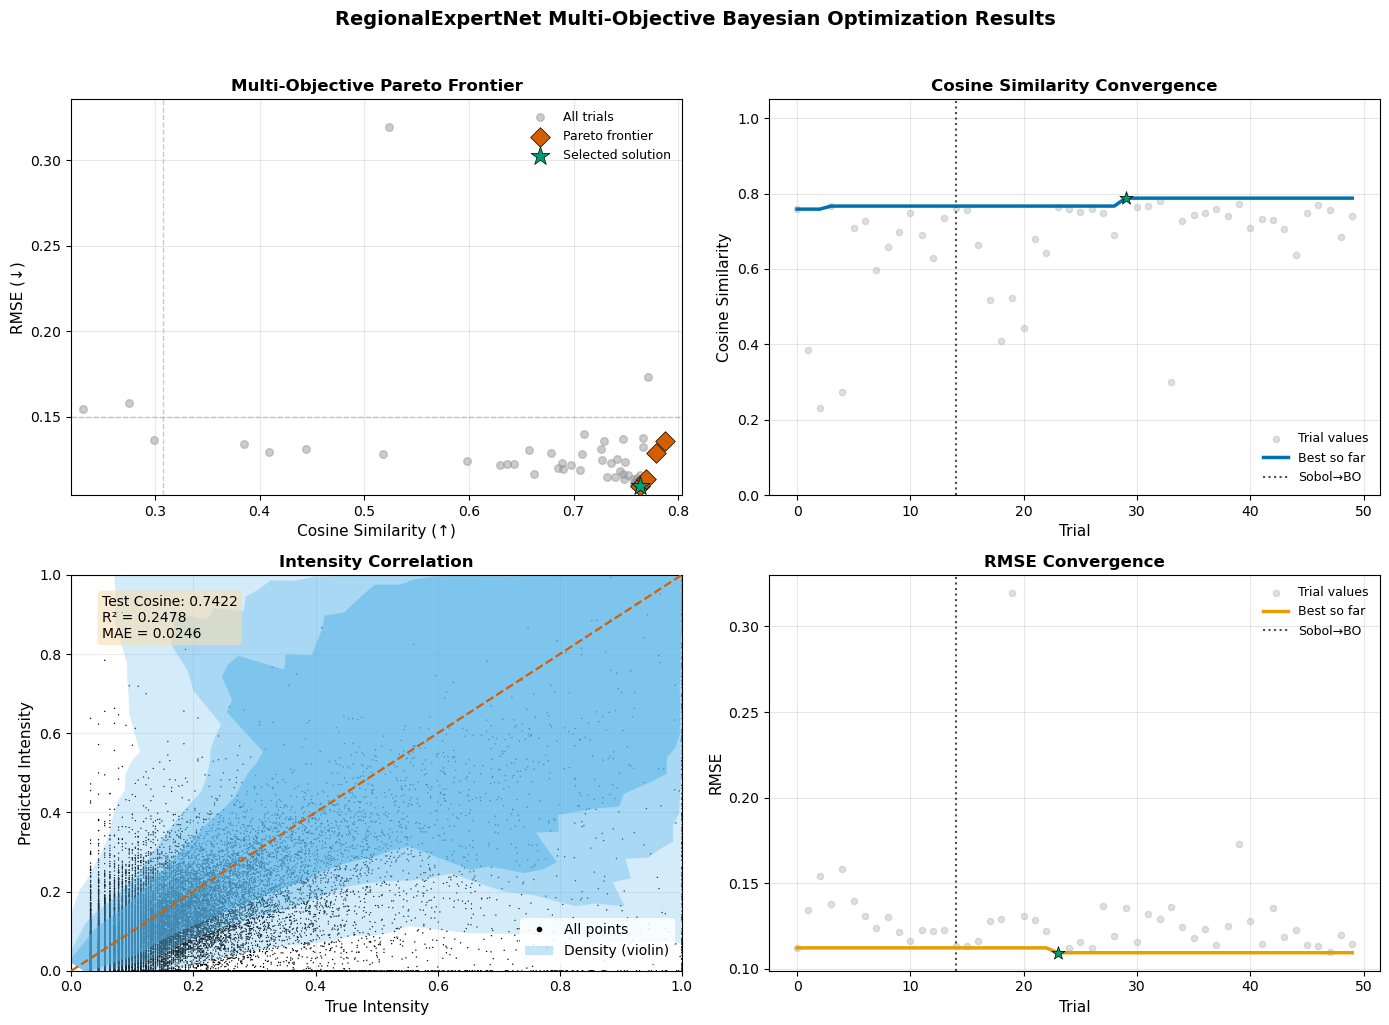

In [18]:
# ============================================================================
# OPTIMIZATION RESULTS VISUALIZATION - STANDARD 2x2 SUITE
# ============================================================================

# Colorblind-friendly Okabe–Ito palette (from standard plots)
PALETTE = {
    "blue": "#0072B2",
    "sky": "#56B4E9",
    "orange": "#E69F00",
    "vermillion": "#D55E00",
    "yellow": "#F0E442",
    "green": "#009E73",
    "purple": "#CC79A7",
    "black": "#000000",
    "grey": "#999999",
}

# Set white background style
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ---------- Top-Left: Pareto Frontier ----------
ax = axes[0, 0]
ax.scatter(df_trials['cosine_similarity'], df_trials['rmse'], 
          alpha=0.5, color=PALETTE["grey"], s=30, label='All trials')
if len(pareto_trials) > 0:
    ax.scatter(pareto_trials['cosine_similarity'], pareto_trials['rmse'], 
              color=PALETTE["vermillion"], s=100, marker='D', 
              edgecolor=PALETTE["black"], linewidth=0.5, label='Pareto frontier')
ax.scatter(best_trial['cosine_similarity'], best_trial['rmse'], 
          color=PALETTE["green"], s=200, marker='*', 
          edgecolor=PALETTE["black"], linewidth=0.5, label='Selected solution')
ax.axvline(cos_threshold, color=PALETTE["grey"], linestyle='--', alpha=0.5, linewidth=1)
ax.axhline(rmse_threshold, color=PALETTE["grey"], linestyle='--', alpha=0.5, linewidth=1)
ax.set_xlabel('Cosine Similarity (↑)', fontsize=11)
ax.set_ylabel('RMSE (↓)', fontsize=11)
ax.set_title('Multi-Objective Pareto Frontier', fontsize=12, fontweight='bold')
ax.legend(frameon=False, fontsize=9, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim([df_trials['cosine_similarity'].min() * 0.95, 
             df_trials['cosine_similarity'].max() * 1.02])
ax.set_ylim([df_trials['rmse'].min() * 0.95, 
             df_trials['rmse'].max() * 1.05])

# ---------- Top-Right: Cosine Similarity Convergence ----------
ax = axes[0, 1]
cosine_history = df_trials['cosine_similarity'].values
best_cosine_history = np.maximum.accumulate(cosine_history)

# Plot trial values as scatter
ax.scatter(range(len(cosine_history)), cosine_history, 
          alpha=0.3, s=20, color=PALETTE["grey"], label='Trial values')
# Plot best so far as line
ax.plot(best_cosine_history, color=PALETTE["blue"], linewidth=2.5, 
        label='Best so far', zorder=5)
# Mark transition from Sobol to BO
ax.axvline(config.n_initial_points, color=PALETTE["black"], 
          linestyle=':', linewidth=1.5, alpha=0.7, label='Sobol→BO')
# Highlight best point
best_idx = np.argmax(cosine_history)
ax.scatter(best_idx, cosine_history[best_idx], color=PALETTE["green"], 
          s=100, marker='*', zorder=10, edgecolor=PALETTE["black"], linewidth=0.5)

ax.set_xlabel('Trial', fontsize=11)
ax.set_ylabel('Cosine Similarity', fontsize=11)
ax.set_title('Cosine Similarity Convergence', fontsize=12, fontweight='bold')
ax.legend(frameon=False, fontsize=9, loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.05])

# ---------- Bottom-Left: Intensity Correlation (Standard Style) ----------
ax = axes[1, 0]

# Prepare data for intensity correlation plot
y_true_flat = np.ravel(data['y_test']).astype(float)
y_pred_flat = np.ravel(y_test_pred).astype(float)
m = np.isfinite(y_true_flat) & np.isfinite(y_pred_flat)
x = y_true_flat[m]
y = y_pred_flat[m]

# Rotate to (u,v) coordinates for violin visualization
root2 = np.sqrt(2.0)
u = (x + y) / root2
v = (y - x) / root2

# Bin along diagonal and compute quantiles
n_bins = 60
u_edges = np.linspace(u.min(), u.max(), n_bins + 1)
u_centers = 0.5 * (u_edges[:-1] + u_edges[1:])
widths_90 = np.full(n_bins, np.nan)
widths_75 = np.full(n_bins, np.nan)
widths_60 = np.full(n_bins, np.nan)
min_count = 10

for i in range(n_bins):
    mask = (u >= u_edges[i]) & (u < u_edges[i+1])
    if np.count_nonzero(mask) >= min_count:
        abs_v = np.abs(v[mask])
        widths_60[i] = np.percentile(abs_v, 60)
        widths_75[i] = np.percentile(abs_v, 75)
        widths_90[i] = np.percentile(abs_v, 90)

# Interpolate and smooth
def _interp_nan(a):
    xidx = np.arange(a.size)
    msk = ~np.isnan(a)
    if msk.sum() < 2:
        return np.nan_to_num(a, nan=0.0)
    return np.interp(xidx, xidx[msk], a[msk])

def _smooth(a, k=5):
    if k <= 1: return a
    kernel = np.ones(k) / k
    return np.convolve(a, kernel, mode='same')

widths_60 = _smooth(_interp_nan(widths_60), 5)
widths_75 = _smooth(_interp_nan(widths_75), 5)
widths_90 = _smooth(_interp_nan(widths_90), 5)

def band_polygon(u_vals, w_vals):
    x_upper = (u_vals - w_vals) / root2
    y_upper = (u_vals + w_vals) / root2
    x_lower = (u_vals + w_vals) / root2
    y_lower = (u_vals - w_vals) / root2
    x_poly = np.r_[x_upper, x_lower[::-1]]
    y_poly = np.r_[y_upper, y_lower[::-1]]
    return x_poly, y_poly

# Scatter points
ax.scatter(x, y, s=4, marker='.', color=PALETTE["black"],
           edgecolors='none', alpha=1.0, zorder=0, rasterized=True)

# Draw violin bands
for w, a in [(widths_90, 0.25), (widths_75, 0.35), (widths_60, 0.5)]:
    xp, yp = band_polygon(u_centers, w)
    ax.fill(xp, yp, color=PALETTE["sky"], alpha=a, edgecolor='none', zorder=2)

# Perfect prediction line
max_val = 1.0  # Clip to 1 as standard
ax.plot([0, max_val], [0, max_val], color=PALETTE["vermillion"],
        linestyle='--', linewidth=1.6, label='Perfect Prediction', zorder=4)

ax.set_xlim(0, max_val)
ax.set_ylim(0, max_val)
ax.set_xlabel('True Intensity', fontsize=11)
ax.set_ylabel('Predicted Intensity', fontsize=11)
ax.set_title('Intensity Correlation', fontsize=12, fontweight='bold')

# Legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
violin_handle = Patch(facecolor=PALETTE["sky"], alpha=0.35, edgecolor='none', label='Density (violin)')
points_handle = Line2D([0], [0], linestyle='none', marker='.', markersize=6,
                       color=PALETTE["black"], label='All points')
ax.legend(handles=[points_handle, violin_handle], loc='lower right',
          frameon=True, facecolor='white', framealpha=0.85, edgecolor='none')
ax.grid(alpha=0.25)

# Metrics annotation
test_cosine = test_metrics['cosine_similarity']
test_r2 = test_metrics['r2']
test_mae = test_metrics['mae']
text = f"Test Cosine: {test_cosine:.4f}\nR² = {test_r2:.4f}\nMAE = {test_mae:.4f}"
ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=10,
        va='top', bbox=dict(boxstyle='round', facecolor='wheat',
        alpha=0.6, edgecolor='none'), zorder=5)

# ---------- Bottom-Right: RMSE Convergence ----------
ax = axes[1, 1]
rmse_history = df_trials['rmse'].values
best_rmse_history = np.minimum.accumulate(rmse_history)

# Plot trial values as scatter
ax.scatter(range(len(rmse_history)), rmse_history, 
          alpha=0.3, s=20, color=PALETTE["grey"], label='Trial values')
# Plot best so far as line
ax.plot(best_rmse_history, color=PALETTE["orange"], linewidth=2.5, 
        label='Best so far', zorder=5)
# Mark transition
ax.axvline(config.n_initial_points, color=PALETTE["black"], 
          linestyle=':', linewidth=1.5, alpha=0.7, label='Sobol→BO')
# Highlight best point
best_idx = np.argmin(rmse_history)
ax.scatter(best_idx, rmse_history[best_idx], color=PALETTE["green"], 
          s=100, marker='*', zorder=10, edgecolor=PALETTE["black"], linewidth=0.5)

ax.set_xlabel('Trial', fontsize=11)
ax.set_ylabel('RMSE', fontsize=11)
ax.set_title('RMSE Convergence', fontsize=12, fontweight='bold')
ax.legend(frameon=False, fontsize=9, loc='upper right')
ax.grid(True, alpha=0.3)

# Overall title
plt.suptitle('RegionalExpertNet Multi-Objective Bayesian Optimization Results', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig(config.models_dir / 'regional_expertnet_optimization_results.png', 
            dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

## 15. Save Results

Save the optimized model and results for future use.

In [15]:
# Prepare results dictionary
optimization_results = {
    'best_parameters': best_params,
    'best_validation_metrics': {
        'cosine_similarity': best_trial['cosine_similarity'],
        'rmse': best_trial['rmse']
    },
    'test_metrics': test_metrics,
    'pareto_frontier': pareto_trials.to_dict('records') if len(pareto_trials) > 0 else [],
    'all_trials': df_trials.to_dict('records'),
    'optimization_time': optimization_time,
    'training_time': train_time,
    'objective_thresholds': {
        'cosine_similarity': cos_threshold,
        'rmse': rmse_threshold
    },
    'model_stats': {
        'total_params': total_params,
        'trainable_params': trainable_params
    },
    'config': vars(config)
}

# Save model and results
model_path = config.models_dir / 'regional_expertnet_optimized.pth'
torch.save({
    'model_state_dict': final_model.state_dict(),
    'model_config': final_model_config,
    'best_params': best_params,
    'scaler': data['final_scaler'],
    'test_metrics': test_metrics
}, model_path)
logger.info(f"Model saved to {model_path}")

# Save optimization results
results_path = config.models_dir / 'regional_expertnet_optimization_results.pkl'
with open(results_path, 'wb') as f:
    pickle.dump(optimization_results, f)
logger.info(f"Results saved to {results_path}")

# Save results as JSON for portability
json_path = config.models_dir / 'regional_expertnet_optimization_results.json'
with open(json_path, 'w') as f:
    json.dump(optimization_results, f, indent=2, default=str)
logger.info(f"Results saved to {json_path}")

# Generate summary report
report_path = config.models_dir / 'regional_expertnet_optimization_report.txt'
with open(report_path, 'w') as f:
    f.write("REGIONALEXPERTNET MULTI-OBJECTIVE BAYESIAN OPTIMIZATION REPORT\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("OPTIMIZATION CONFIGURATION\n")
    f.write("-" * 30 + "\n")
    f.write(f"Total trials: {config.n_iterations}\n")
    f.write(f"Initial points (Sobol): {config.n_initial_points}\n")
    f.write(f"Batch size: {config.batch_size}\n")
    f.write(f"Parallel workers: {min(config.batch_size, os.cpu_count())}\n")
    f.write(f"Max epochs (eval): {config.max_epochs_eval}\n")
    f.write(f"Max epochs (final): {config.final_max_epochs}\n")
    f.write(f"Optimization time: {optimization_time:.1f}s\n\n")
    
    f.write("OBJECTIVE THRESHOLDS\n")
    f.write("-" * 30 + "\n")
    f.write(f"Cosine similarity >= {cos_threshold:.4f}\n")
    f.write(f"RMSE <= {rmse_threshold:.4f}\n\n")
    
    f.write("BEST HYPERPARAMETERS\n")
    f.write("-" * 30 + "\n")
    for param, value in best_params.items():
        f.write(f"{param:<25}: {value}\n")
    
    f.write("\nPERFORMANCE METRICS\n")
    f.write("-" * 30 + "\n")
    f.write(f"Validation Cosine (subsample): {best_trial['cosine_similarity']:.6f}\n")
    f.write(f"Validation RMSE (subsample): {best_trial['rmse']:.6f}\n")
    f.write(f"Validation Cosine (full): {full_eval['cosine_similarity'][0]:.6f}\n")
    f.write(f"Validation RMSE (full): {full_eval['rmse'][0]:.6f}\n")
    f.write(f"Test Cosine: {test_metrics['cosine_similarity']:.6f}\n")
    f.write(f"Test RMSE: {test_metrics['rmse']:.6f}\n")
    f.write(f"Test MAE: {test_metrics['mae']:.6f}\n")
    f.write(f"Test R²: {test_metrics['r2']:.6f}\n")
    
    f.write("\nMODEL ARCHITECTURE\n")
    f.write("-" * 30 + "\n")
    f.write(f"Total parameters: {total_params:,}\n")
    f.write(f"Trainable parameters: {trainable_params:,}\n")
    f.write(f"Number of regions: {best_params['num_regions']}\n")
    f.write(f"Region size: {best_params['region_size']}\n")
    f.write(f"Expert layers: {best_params['expert_layers']}\n")
    f.write(f"Expert hidden: {best_params['expert_hidden']}\n")
    f.write(f"Router hidden: {best_params['router_hidden']}\n")
    f.write(f"Overlap bins: {best_params['overlap_bins']}\n")
    
    f.write("\nPARETO FRONTIER\n")
    f.write("-" * 30 + "\n")
    f.write(f"Number of Pareto-optimal solutions: {len(pareto_trials)}\n")
    if len(pareto_trials) > 0:
        f.write(f"Cosine range: [{pareto_trials['cosine_similarity'].min():.4f}, "
               f"{pareto_trials['cosine_similarity'].max():.4f}]\n")
        f.write(f"RMSE range: [{pareto_trials['rmse'].min():.4f}, "
               f"{pareto_trials['rmse'].max():.4f}]\n")

logger.info(f"Report saved to {report_path}")

print("\n" + "=" * 60)
print("OPTIMIZATION COMPLETE")
print("=" * 60)
print(f"Optimization time: {optimization_time:.1f}s ({optimization_time/60:.1f} minutes)")
print(f"Training time: {train_time:.1f}s")
print(f"\nBest validation performance:")
print(f"  Cosine Similarity: {best_trial['cosine_similarity']:.6f}")
print(f"  RMSE: {best_trial['rmse']:.6f}")
print(f"\nTest set performance:")
print(f"  Cosine Similarity: {test_metrics['cosine_similarity']:.6f}")
print(f"  RMSE: {test_metrics['rmse']:.6f}")
print(f"\nPareto frontier contains {len(pareto_trials)} solutions")
print(f"All results saved to {config.models_dir}")

2025-08-18 12:48:01,553 - INFO - Model saved to ../models/bayesian_optimized/regional_expertnet_optimized.pth
2025-08-18 12:48:01,554 - INFO - Results saved to ../models/bayesian_optimized/regional_expertnet_optimization_results.pkl
2025-08-18 12:48:01,556 - INFO - Results saved to ../models/bayesian_optimized/regional_expertnet_optimization_results.json
2025-08-18 12:48:01,557 - INFO - Report saved to ../models/bayesian_optimized/regional_expertnet_optimization_report.txt



OPTIMIZATION COMPLETE
Optimization time: 1110.3s (18.5 minutes)
Training time: 233.0s

Best validation performance:
  Cosine Similarity: 0.763847
  RMSE: 0.109451

Test set performance:
  Cosine Similarity: 0.742188
  RMSE: 0.073187

Pareto frontier contains 4 solutions
All results saved to ../models/bayesian_optimized
